# <font color='Green'> Gesture Recognition


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 
In this group project, we are going to build a CNN+RNN and 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
## Checking the GPU configuration

!nvidia-smi

Tue Dec 28 04:29:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import all the relavent libraries
import numpy as np
import os
import cv2
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [ ]:
import os 
if not os.path.exists('/content/Project_data/'):
  os.system('gdown --id 1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL')
  os.system('7z x Project_data.zip')

In [ ]:
project_folder='/content/Project_data'

##### Plotting

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image, (self.image_height, self.image_width), interpolation=cv2.INTER_AREA)
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped, (self.image_height, self.image_width), interpolation=cv2.INTER_AREA)
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        path_checkpoint='/content/drive/MyDrive/Gesture/Checkpoints/'

        filepath = path_checkpoint + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=18,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 18, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 80, 80, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 80, 80, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 9, 80, 80, 32)     0

##### Sample Cropping

In [ ]:
#test_generator=ModelConv3D1()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,15,:,:,:])   
#axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6533 - categorical_accuracy: 0.4072
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_08_30.910098/model-00001-1.65327-0.40724-2.40016-0.21000.h5
23/23 [==============================] - 45s 1s/step - loss: 1.6533 - categorical_accuracy: 0.4072 - val_loss: 2.4002 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
22/23 [===========================>..] - ETA: 1s - loss: 1.0978 - categorical_accuracy: 0.5697
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_08_30.910098/model-00002-1.10337-0.56863-3.80654-0.21000.h5
23/23 [==============================] - 32s 1s/step - loss: 1.1034 - categorical_accuracy: 0.5686 - val_loss: 3.8065 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
22/23 [===========================>..] - ETA: 1s - loss: 0.8858 - categorical_accuracy: 0.6545
Epoch 00003: saving

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6016 - categorical_accuracy: 0.4042
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_10_24.060405/model-00001-1.60157-0.40422-2.14789-0.16000.h5
23/23 [==============================] - 51s 2s/step - loss: 1.6016 - categorical_accuracy: 0.4042 - val_loss: 2.1479 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1513 - categorical_accuracy: 0.5370
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_10_24.060405/model-00002-1.15130-0.53695-3.78605-0.16000.h5
23/23 [==============================] - 50s 2s/step - loss: 1.1513 - categorical_accuracy: 0.5370 - val_loss: 3.7860 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
11/12 [==========================>...] - ETA: 3s - loss: 1.7716 - categorical_accuracy: 0.3530
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_12_07.385542/model-00001-1.77084-0.35294-1.62896-0.22000.h5
12/12 [==============================] - 53s 5s/step - loss: 1.7708 - categorical_accuracy: 0.3529 - val_loss: 1.6290 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 3s - loss: 1.0610 - categorical_accuracy: 0.5970
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_12_07.385542/model-00002-1.05929-0.59729-1.99662-0.21000.h5
12/12 [==============================] - 49s 4s/step - loss: 1.0593 - categorical_accuracy: 0.5973 - val_loss: 1.9966 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6760 - categorical_accuracy: 0.3710
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_13_52.642151/model-00001-1.67595-0.37104-1.60822-0.23000.h5
12/12 [==============================] - 28s 2s/step - loss: 1.6760 - categorical_accuracy: 0.3710 - val_loss: 1.6082 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 2s - loss: 1.1072 - categorical_accuracy: 0.5712
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_13_52.642151/model-00002-1.10513-0.57315-1.90736-0.17000.h5
12/12 [==============================] - 26s 2s/step - loss: 1.1051 - categorical_accuracy: 0.5732 - val_loss: 1.9074 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7864 - categorical_accuracy: 0.3454
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_14_49.680314/model-00001-1.78635-0.34540-1.64771-0.16000.h5
9/9 [==============================] - 29s 3s/step - loss: 1.7864 - categorical_accuracy: 0.3454 - val_loss: 1.6477 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.1581 - categorical_accuracy: 0.5339
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_14_49.680314/model-00002-1.15813-0.53394-2.37611-0.18000.h5
9/9 [==============================] - 25s 3s/step - loss: 1.1581 - categorical_accuracy: 0.5339 - val_loss: 2.3761 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4800 - categorical_accuracy: 0.4585
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_15_46.363561/model-00001-1.48002-0.45852-9.98548-0.16000.h5
45/45 [==============================] - 61s 1s/step - loss: 1.4800 - categorical_accuracy: 0.4585 - val_loss: 9.9855 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0698 - categorical_accuracy: 0.5928
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_15_46.363561/model-00002-1.06978-0.59276-11.90139-0.15000.h5
45/45 [==============================] - 59s 1s/step - loss: 1.0698 - categorical_accuracy: 0.5928 - val_loss: 11.9014 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
44/45 [============================>.] - ETA: 0s - loss: 1.4883 - categorical_accuracy: 0.4348
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_17_46.973281/model-00001-1.48768-0.43439-6.15142-0.16000.h5
45/45 [==============================] - 33s 708ms/step - loss: 1.4877 - categorical_accuracy: 0.4344 - val_loss: 6.1514 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
44/45 [============================>.] - ETA: 0s - loss: 1.0716 - categorical_accuracy: 0.5682
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_17_46.973281/model-00002-1.06910-0.57014-6.62293-0.17000.h5
45/45 [==============================] - 31s 707ms/step - loss: 1.0691 - categorical_accuracy: 0.5701 - val_loss: 6.6229 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.7127 - categorical_accuracy: 0.3650
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_19_49.127565/model-00001-1.71270-0.36501-2.66908-0.21000.h5
67/67 [==============================] - 29s 409ms/step - loss: 1.7127 - categorical_accuracy: 0.3650 - val_loss: 2.6691 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.3410 - categorical_accuracy: 0.4992
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_19_49.127565/model-00002-1.34102-0.49925-3.84096-0.24000.h5
67/67 [==============================] - 27s 414ms/step - loss: 1.3410 - categorical_accuracy: 0.4992 - val_loss: 3.8410 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5385 - categorical_accuracy: 0.4253
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_25_30.866812/model-00001-1.53854-0.42534-2.25371-0.16000.h5
17/17 [==============================] - 34s 2s/step - loss: 1.5385 - categorical_accuracy: 0.4253 - val_loss: 2.2537 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.9886 - categorical_accuracy: 0.6063
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_25_30.866812/model-00002-0.98865-0.60633-5.11952-0.17000.h5
17/17 [==============================] - 31s 2s/step - loss: 0.9886 - categorical_accuracy: 0.6063 - val_loss: 5.1195 - val_categorical_accuracy: 0.1700 - lr: 0.0010


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5872 - categorical_accuracy: 0.4012
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_26_37.390670/model-00001-1.58715-0.40121-1.56310-0.33000.h5
17/17 [==============================] - 41s 2s/step - loss: 1.5872 - categorical_accuracy: 0.4012 - val_loss: 1.5631 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0163 - categorical_accuracy: 0.6199
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_26_37.390670/model-00002-1.01628-0.61991-2.26930-0.24000.h5
17/17 [==============================] - 39s 2s/step - loss: 1.0163 - categorical_accuracy: 0.6199 - val_loss: 2.2693 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7551 - categorical_accuracy: 0.7285
Epoch 00003: sav

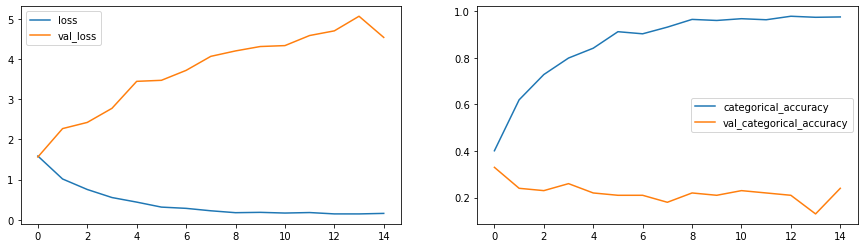

In [ ]:
plot(history_model1)

#### Model is clearly overfitting. Need to do the following to avoid the over fitting 

1. Add some Dropout Layers 
2. Regularization should be implemented to overcome the problem of Overfitting
3. Need to do Data Augmentation


# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9603 - categorical_accuracy: 0.3846
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_36_21.465456/model-00001-1.96028-0.38462-1.94398-0.23000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.9603 - categorical_accuracy: 0.3846 - val_loss: 1.9440 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5776 - categorical_accuracy: 0.4751
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2718_36_21.465456/model-00002-1.57761-0.47511-2.43907-0.30000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.5776 - categorical_accuracy: 0.4751 - val_loss: 2.4391 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3428 - categorical_accuracy: 0.5468
Epoch 00003: sav

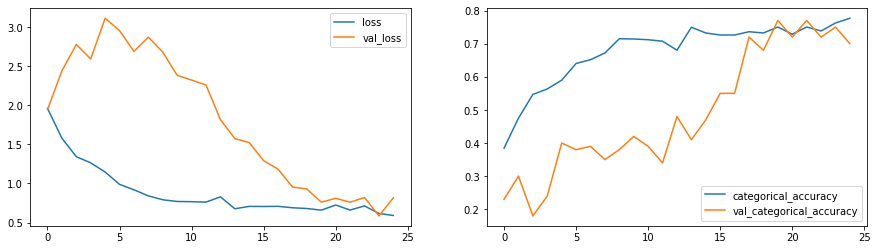

In [ ]:
plot(history_model2)

#### Model is not overfitting, and we get a best validation accuracy of 76% and training accuracy of 75%. Next, we will try to reduce the filter size and image resolution and see if we get better results. Moreover, since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002.


# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)   

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0826 - categorical_accuracy: 0.3371
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2719_09_04.766720/model-00001-2.08256-0.33710-1.77860-0.16000.h5
23/23 [==============================] - 52s 2s/step - loss: 2.0826 - categorical_accuracy: 0.3371 - val_loss: 1.7786 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
22/23 [===========================>..] - ETA: 2s - loss: 1.5424 - categorical_accuracy: 0.4871
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2719_09_04.766720/model-00002-1.54805-0.48643-2.83952-0.13000.h5
23/23 [==============================] - 50s 2s/step - loss: 1.5480 - categorical_accuracy: 0.4864 - val_loss: 2.8395 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
22/23 [===========================>..] - ETA: 2s - loss: 1.2335 - categorical_accuracy: 0.5659
Epoch 00

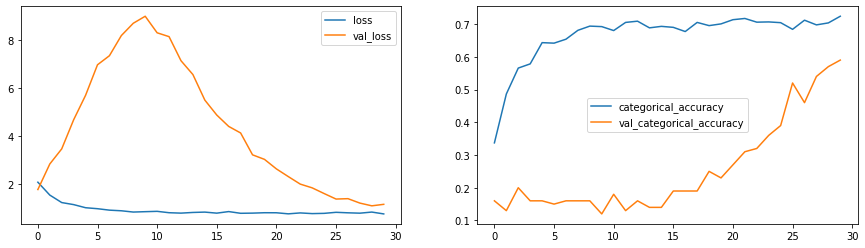

In [ ]:
plot(history_model3)

#### Model has a best validation accuracy of 76% and training accuracy of 75%. Also, we were able to reduce the parameter size by half the earlier model. Let's trying to add more layers.

# Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_108 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_73 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_73 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_109 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9954 - categorical_accuracy: 0.3793
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2719_34_33.799713/model-00001-1.99536-0.37934-2.48075-0.21000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.9954 - categorical_accuracy: 0.3793 - val_loss: 2.4808 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5587 - categorical_accuracy: 0.4774
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2719_34_33.799713/model-00002-1.55866-0.47738-3.41019-0.22000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.5587 - categorical_accuracy: 0.4774 - val_loss: 3.4102 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3279 - categorical_accuracy: 0.5460
Epoch 00003: sav

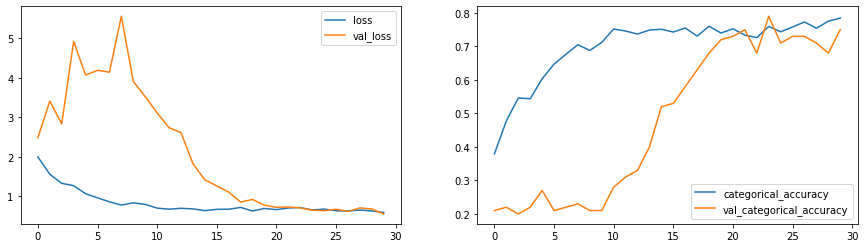

In [ ]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_80 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_80 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_118 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_81 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_81 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_119 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7222 - categorical_accuracy: 0.4005
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2720_00_58.665313/model-00001-1.72223-0.40045-1.93202-0.16000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.7222 - categorical_accuracy: 0.4005 - val_loss: 1.9320 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.2947 - categorical_accuracy: 0.5173
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2720_00_58.665313/model-00002-1.29472-0.51735-1.95544-0.23000.h5
34/34 [==============================] - 51s 2s/step - loss: 1.2947 - categorical_accuracy: 0.5173 - val_loss: 1.9554 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.1504 - categorical_accuracy: 0.5513
Epoch 00003: sav

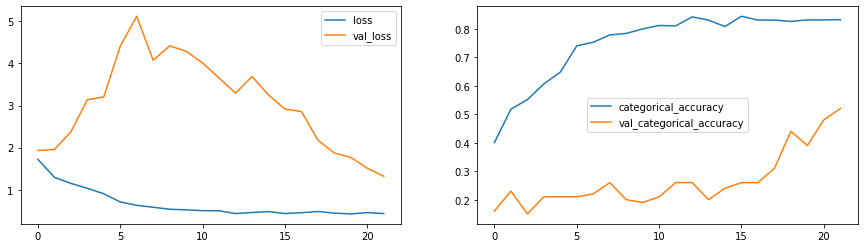

In [ ]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 50, 50, 32)     0

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9713 - categorical_accuracy: 0.3137
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2804_30_27.991051/model-00001-1.97131-0.31373-1.85988-0.16000.h5
34/34 [==============================] - 55s 1s/step - loss: 1.9713 - categorical_accuracy: 0.3137 - val_loss: 1.8599 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3102 - categorical_accuracy: 0.4940
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2804_30_27.991051/model-00002-1.31022-0.49397-2.76522-0.20000.h5
34/34 [==============================] - 44s 1s/step - loss: 1.3102 - categorical_accuracy: 0.4940 - val_loss: 2.7652 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
33/34 [============================>.] - ETA: 1s - loss: 1.0441 - categorical_accuracy: 0.5992
Epoch 000

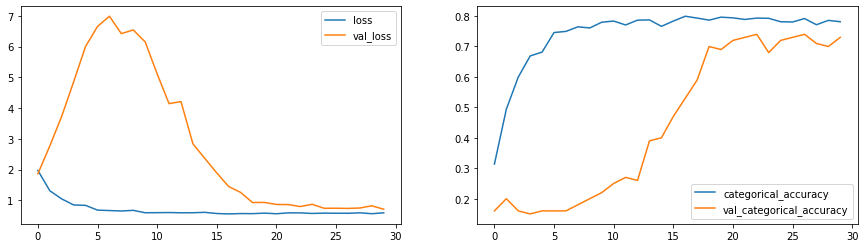

In [ ]:
plot(history_model6)

#### Overfitting decrease, decent validation accuracy of 74% with significant drop in the number of parameters.

# Model 7 - reducing the number of parameters

In [ ]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7522 - categorical_accuracy: 0.3620
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2804_52_52.352090/model-00001-1.75225-0.36199-1.90320-0.16000.h5
34/34 [==============================] - 47s 1s/step - loss: 1.7522 - categorical_accuracy: 0.3620 - val_loss: 1.9032 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1990 - categorical_accuracy: 0.5415
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2804_52_52.352090/model-00002-1.19902-0.54148-2.81983-0.15000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.1990 - categorical_accuracy: 0.5415 - val_loss: 2.8198 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0111 - categorical_accuracy: 0.6071
Epoch 000

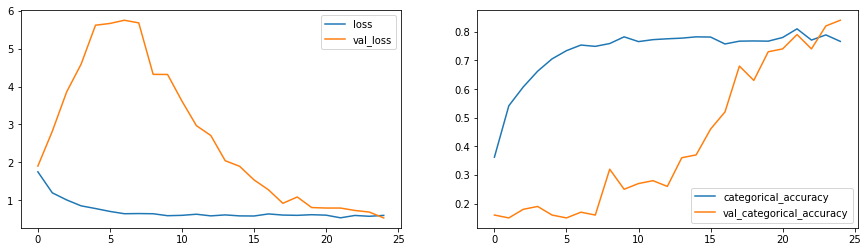

In [ ]:
plot(history_model7)

#### Further decrease in number of parameters, observed a increase in the validation score to 84%.

# Model 8 - reducing the number of parameters

In [ ]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 8)   656       
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 16)    

In [ ]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0287 - categorical_accuracy: 0.2602
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2805_12_00.808268/model-00001-2.02874-0.26018-1.81320-0.21000.h5
34/34 [==============================] - 47s 1s/step - loss: 2.0287 - categorical_accuracy: 0.2602 - val_loss: 1.8132 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4609 - categorical_accuracy: 0.4412
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2805_12_00.808268/model-00002-1.46087-0.44118-2.36758-0.18000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.4609 - categorical_accuracy: 0.4412 - val_loss: 2.3676 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/30
33/34 [============================>.] - ETA: 1s - loss: 1.2608 - categorical_accuracy: 0.5136
Epoch 000

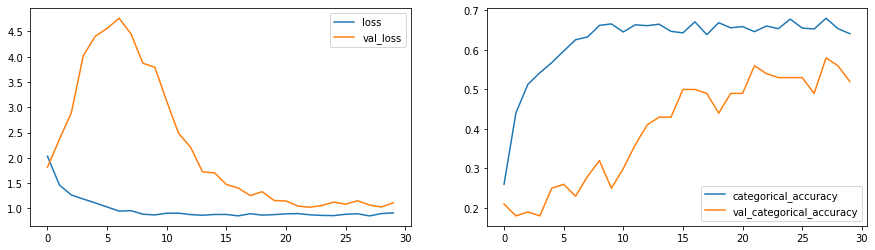

In [ ]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 78%

# Model 9 - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5031 - categorical_accuracy: 0.3620
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2805_34_55.070043/model-00001-1.50314-0.36199-1.65186-0.28000.h5
34/34 [==============================] - 55s 2s/step - loss: 1.5031 - categorical_accuracy: 0.3620 - val_loss: 1.6519 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1761 - categorical_accuracy: 0.5083
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2805_34_55.070043/model-00002-1.17612-0.50830-2.01834-0.21000.h5
34/34 [==============================] - 51s 2s/step - loss: 1.1761 - categorical_accuracy: 0.5083 - val_loss: 2.0183 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0855 - categorical_accuracy: 0.5543
Epoch 00003: sav

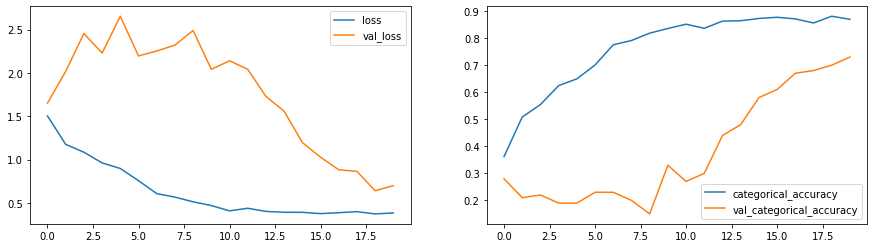

In [ ]:
plot(history_model9)

#### For CNN - LSTM model we get a best validation accuracy of 73%

# Model 10 - CNN with GRU - Similar to Model 9

In [ ]:
class RNNCNN2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4098 - categorical_accuracy: 0.4163
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_04_08.680393/model-00001-1.40981-0.41629-1.85414-0.16000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.4098 - categorical_accuracy: 0.4163 - val_loss: 1.8541 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
33/34 [============================>.] - ETA: 1s - loss: 1.0074 - categorical_accuracy: 0.6023
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_04_08.680393/model-00002-1.00813-0.60181-2.21657-0.16000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.0081 - categorical_accuracy: 0.6018 - val_loss: 2.2166 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.8133 - categorical_accuracy: 0.7061
Epoch 00

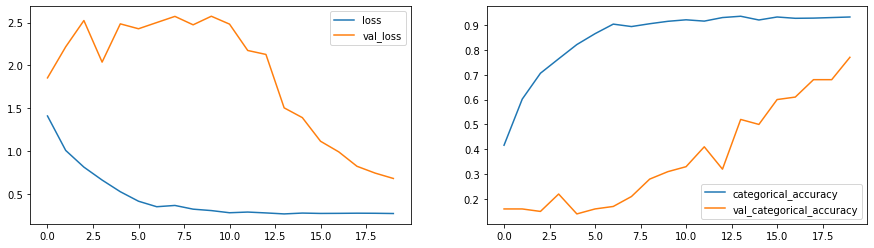

In [ ]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 11 - Transfer Learning

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3863 - categorical_accuracy: 0.4035
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_28_58.011311/model-00001-1.38629-0.40347-1.00227-0.59000.h5
133/133 [==============================] - 53s 370ms/step - loss: 1.3863 - categorical_accuracy: 0.4035 - val_loss: 1.0023 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9290 - categorical_accuracy: 0.6342
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_28_58.011311/model-00002-0.92897-0.63424-0.79939-0.67000.h5
133/133 [==============================] - 48s 366ms/step - loss: 0.9290 - categorical_accuracy: 0.6342 - val_loss: 0.7994 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7398 - categorical_accuracy: 0.7247


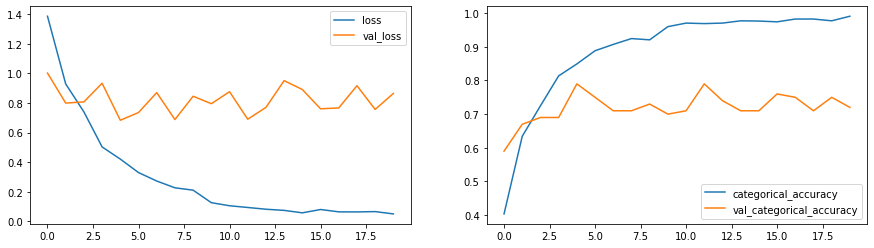

In [ ]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 12 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_46 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1913 - categorical_accuracy: 0.4955
Epoch 00001: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_45_12.345146/model-00001-1.19129-0.49548-0.58293-0.77000.h5
133/133 [==============================] - 54s 375ms/step - loss: 1.1913 - categorical_accuracy: 0.4955 - val_loss: 0.5829 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7126 - categorical_accuracy: 0.7225
Epoch 00002: saving model to /content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_45_12.345146/model-00002-0.71256-0.72247-0.45381-0.80000.h5
133/133 [==============================] - 49s 372ms/step - loss: 0.7126 - categorical_accuracy: 0.7225 - val_loss: 0.4538 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4528 - categorical_accuracy: 0.8190


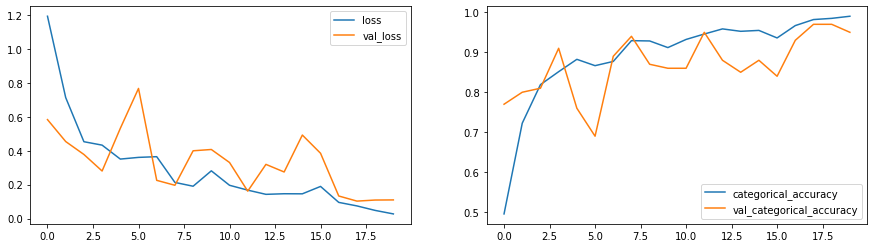

In [ ]:
plot(history_model19)

#### Transfer Learning+GRU: When trained all the weights with transfer learning + GRU, we are getting the best validation score of 97%.


### <font color='Green'>  Loading the best model and evaluating (Model:12 Transfer Learning+GRU with train accuracy:98% & Valadiation accuracy 97%) 

In [ ]:
import time
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Gesture/Checkpoints/model_init_2021-12-2806_45_12.345146/model-00018-0.07487-0.98190-0.10318-0.97000.h5')

In [ ]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=100,num_epochs=20)

In [ ]:
g=test_generator.generator(test_generator.val_path,test_generator.val_doc)
batch_data, batch_labels=next(g)

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 3 2 2 0 1 0 2 1 1 3 4 3 3 2 1 0 3 0 2 4 0 3 2 0 3 0 1 1 3 1 0 3 4 3 2 1
 0 2 0 0 1 2 4 0 3 0 0 1 4 1 2 1 3 3 4 0 1 3 0 1 1 2 0 4 4 0 4 0 1 4 0 1 3
 3 0 1 2 2 3 4 2 2 4 0 3 4 2 2 4 3 2 1 2 1 3 3 1 2 4]


In [ ]:
print(np.argmax(batch_labels,axis=1))

[2 3 2 2 0 1 0 2 1 1 3 4 3 3 2 1 2 3 4 2 4 1 3 2 0 3 0 1 1 3 1 0 3 4 3 2 1
 0 2 0 1 1 2 4 0 3 0 0 1 4 1 2 1 3 3 4 0 1 3 0 1 1 2 0 4 4 0 4 0 1 4 0 1 3
 3 0 1 2 2 3 4 2 2 4 0 3 4 2 2 4 3 2 1 2 1 3 3 1 2 4]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Classfication report for the best model based on the experiments elaborated above

In [ ]:
print(classification_report(np.argmax(batch_labels,axis=1), np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       1.00      0.91      0.95        23
           2       1.00      0.95      0.98        22
           3       1.00      1.00      1.00        21
           4       1.00      0.94      0.97        16

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.97      0.96      0.96       100



#### Confusion matrix for the best model based on the experiments elaborated above

In [ ]:
confusion_mat=confusion_matrix(np.argmax(batch_labels,axis=1), np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))
print(confusion_mat)

[[18  0  0  0  0]
 [ 2 21  0  0  0]
 [ 1  0 21  0  0]
 [ 0  0  0 21  0]
 [ 1  0  0  0 15]]


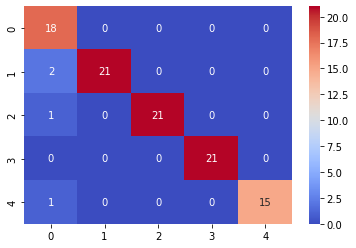

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mat,cmap='coolwarm',annot=True)

### `Thanks for the Assignment` 